# Long Short Term Memory(LSTM) based - Stock predicition - - # CPU based


Aim -to predict the Closing_Price_Prediction using past 60 day stock price.

In [2]:
import math
import numpy as np
import pandas as pd
# import pandas_datareader as web
#from sklearn.tree import DecisionTreeRegressor
#from sklearn.linear_model import LinearRegression
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

#plt.style.use('fivethirtyeight')
#plt.style.use('fivethirtyeight')
plt.style.use('seaborn-v0_8-dark')


2024-04-30 17:08:46.606277: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-30 17:08:46.635408: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 17:08:47.111725: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data prep

Works on Yahoo based data. (Doesnt contain Indian stock values) 

In [3]:
ticker = 'AMZN'  #amazon  start=   end = current date

In [4]:
ticker = 'TSLA'  #Tesla start=   end = current date

In [5]:
ticker = 'UBER'  #Uber start=   end = current date

In [6]:
ticker = 'TSLA'  #Tesla start=   end = current date

Change start and end date for collection, as per Company.  (Start date cant be before the company was founded.)

Different approaches can be used for Date collection - 


1.   Pretrain on 20+ year dataset, finetune for local
2.   Event specific timings - As in 2020, covid may lead to a new stock trading pattern.



In [7]:
#Get stock quote - we import just the opening and closing Prices of stock, over 20 years duration

df=pd.read_csv("Combining Stock and Twitter Data/RawData/FiveYearData_AMZN.csv")   #YYYY-MM-DD
df

,date,open,low,high,volume,close,Name
0,1/2/14,398.80,394.02,399.36,2137800.0,397.97,AMZN
1,1/3/14,398.29,396.22,402.71,2210200.0,396.44,AMZN
2,1/6/14,395.85,388.42,397.00,3170600.0,393.63,AMZN
3,1/7/14,395.04,394.29,398.47,1916000.0,398.03,AMZN
4,1/8/14,398.47,396.04,403.00,2316500.0,401.92,AMZN
...,...,...,...,...,...,...,...
1060,3/21/18,1586.45,1563.17,1590.00,4667291.0,1581.86,AMZN
1061,3/22/18,1565.47,1542.40,1573.85,6177737.0,1544.10,AMZN
1062,3/23/18,1539.01,1495.36,1549.02,7843966.0,1495.56,AMZN
1063,3/26/18,1530.00,1499.25,1556.99,5547618.0,1555.86,AMZN


In [8]:
df.shape

(1065, 7)

In [9]:
#choose plotting style

#plt.style.use('fivethirtyeight')
plt.style.use('dark_background')
#plt.style.use('ggplot')
#plt.style.use('seaborn-whitegrid')
#plt.style.use('bmh')
#plt.style.use('seaborn')

In [10]:
data=df.filter(['close'])

#Convert to np array
dataset=data.values

#Get the number of rows to train the model on
#math.ceil to round up 

training_data_len = math.ceil(len(dataset)*.8)


#print(dataset)
training_data_len

852

In [11]:
#Scale the data

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.08465504],
       [0.08348838],
       [0.0813457 ],
       ...,
       [0.92159001],
       [0.96757   ],
       [0.92272616]])

In [12]:
#Create training dataset
#Create scaled training dataset

train_data = scaled_data[0:training_data_len,:]

#Split the data into x_train and y_train data set

x_train=[]
y_train=[]

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    if i<=60:
        print(x_train)
        print(y_train)
        print()

len(x_train)

[array([0.08465504, 0.08348838, 0.0813457 , 0.08470079, 0.08766699,
       0.0869731 , 0.08441865, 0.07932502, 0.08432715, 0.08305374,
       0.08300037, 0.08590557, 0.09157872, 0.0896648 , 0.08610382,
       0.0767477 , 0.07574117, 0.08195571, 0.07415513, 0.08849814,
       0.05470323, 0.04514122, 0.04651376, 0.04536997, 0.05157689,
       0.05652565, 0.05636552, 0.05706704, 0.04750503, 0.05356707,
       0.05368145, 0.05086012, 0.04607912, 0.04792442, 0.04560636,
       0.04943421, 0.05442109, 0.05554962, 0.05580126, 0.05730342,
       0.05553437, 0.05867596, 0.06513451, 0.06497438, 0.06489813,
       0.06373147, 0.06242756, 0.06381535, 0.06447874, 0.06617916,
       0.06717044, 0.07001464, 0.06579028, 0.06254194, 0.05617489,
       0.04948759, 0.0516684 , 0.04305191, 0.03928506, 0.03914781])]
[0.0376799548587812]



792

In [13]:
#convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [14]:
#Reshape the data into 3 dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(792, 60, 1)

## Model training 

In [15]:
#Build LSTM model
model=Sequential()
#Add first layer to model
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
#Add second layer to model
model.add(LSTM(50, return_sequences=False))
#Add Dense Layer to model with 25 neurons
model.add(Dense(25))
#Add Dense Layer to model with 1 neuron
model.add(Dense(1))

2024-04-30 17:08:47.655727: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-30 17:08:47.655976: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/netradeepakc/anaconda3/envs/RecSys/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the

In [16]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [17]:
#Train the model
model.fit(x_train, y_train, batch_size=1,epochs=3 )

Epoch 1/3


792/792 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0032
Epoch 2/3
792/792 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 6.2999e-04
Epoch 3/3
792/792 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 3.3575e-04


## Testing and Validating model

In [18]:
#Create the test data set
#Create a new array containing scaled values

test_data=scaled_data[training_data_len-60: , : ]
#Create the data sets x_test and y_test

x_test=[]
y_test=dataset[training_data_len:,:]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])
    


In [19]:
#Convert the data to a numpy array

x_test=np.array(x_test)


In [20]:
#Reshape the data to 3d
x_test=np.reshape(x_test,(x_test.shape[0], x_test.shape[1], 1))


In [21]:
#Get the models predicted price values

predictions=model.predict(x_test)
predictions=scaler.inverse_transform(predictions)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [22]:
#Get root mean squared error(RMSE)

rmse =np.sqrt(np.mean(predictions-y_test)**2)
rmse



nan

In [23]:
#choose plotting style

#plt.style.use('fivethirtyeight')
plt.style.use('dark_background')
#plt.style.use('ggplot')
#plt.style.use('seaborn-whitegrid')
#plt.style.use('bmh')
#plt.style.use('seaborn')

/tmp/ipykernel_124593/389461932.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = predictions


KeyError: 'Close'

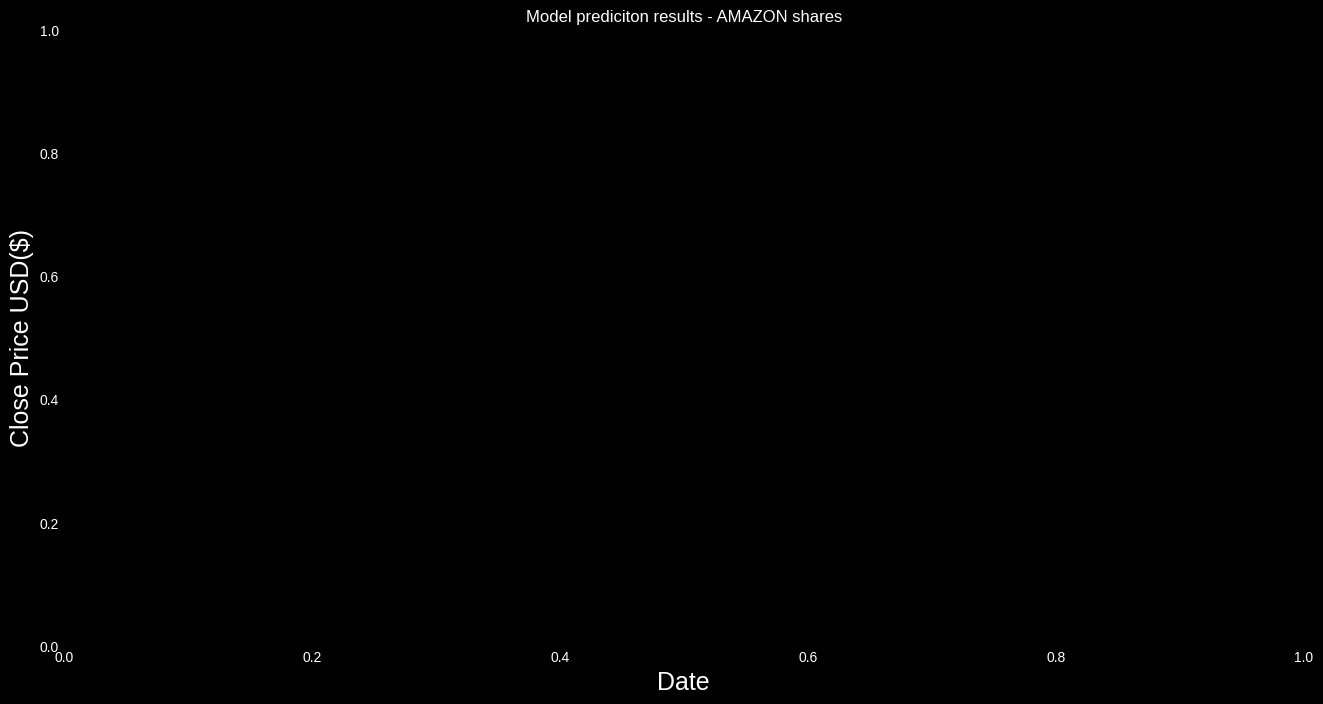

In [24]:
#plot the data

train=data[:training_data_len]
valid=data[training_data_len:]
valid['predictions'] = predictions

#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model prediciton results - AMAZON shares')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD($)', fontsize=18)
plt.plot(train['Close'] , color='red')
plt.plot(valid['Close'] , color='yellow')
plt.plot(valid[ 'predictions'] , color='green')
plt.legend(['Train','Validation', 'predictions'], loc='lower right')
plt.savefig('/content/prediction.png')
plt.show()

In [ ]:
#Show the valid and predicted prices

valid.tail(15)

,Close,predictions
Date,,
2020-05-04,2315.989990,2353.478760
2020-05-05,2317.800049,2339.276611
2020-05-06,2351.260010,2327.780029
2020-05-07,2367.610107,2326.094238
2020-05-08,2379.610107,2330.867188
2020-05-11,2409.000000,2339.045166
2020-05-12,2356.949951,2352.319580
2020-05-13,2367.919922,2354.082520
2020-05-14,2388.850098,2354.481934


# Getting predicitions - for tomorrow

In [ ]:
#Get the quote
stock_quote = web.DataReader(ticker, data_source='yahoo', start='2012-01-01', end='2020-05-25')

new_df=stock_quote.filter(['Close'])
#Get last 60 days values and convert into array
last_60_days=new_df[-60:].values

#Scale the data to be values between 0
last_60_days_scaled=scaler.transform(last_60_days)

#Create an empty list
X_test=[]
#Appemd the past 60days
X_test.append(last_60_days_scaled)

#Conver the X_test data into numpy array
X_test = np.array(X_test)

#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
#Get predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling
pred_price=scaler.inverse_transform(pred_price)
print(f'Price of {ticker} tomorrow:{pred_price}')

Price of AMZN tomorrow:[[2421.2363]]


## Getting predicitions for 2 months from now ?

In [ ]:
#Get the quote
stock_quote = web.DataReader(ticker, data_source='yahoo', start='2012-01-01', end='2020-05-24')

new_df=stock_quote.filter(['Open'])
#Get last 60 days values and convert into array
last_60_days=new_df[-60:].values

#Scale the data to be values between 0
last_60_days_scaled=scaler.transform(last_60_days)

#Create an empty list
X_test=[]
#Appemd the past 60days
X_test.append(last_60_days_scaled)

#Conver the X_test data into numpy array
X_test = np.array(X_test)

#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
#Get predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling
pred_price=scaler.inverse_transform(pred_price)
print(f'Opening Price of {ticker} tomorrow:{pred_price}')